# GMT DoF generation
The purpose of this demo is to generate the resultant WF in the exit pupil for the following GMT DoF:
1) M1 bending modes (could be swapped to Zernikes if decided)
2) M1 Rigid Body Motions
3) M2 Rigid Body Motions
4) M2 Zernike modes (TBC)

In [1]:
#----- CEO: GMT ray-tracing and wavefront sensing simulator
import ceo

#----- System related packages
import sys
import datetime
import os.path

#----- Math and Scientific Computing
import numpy as np

#----- Visualization
%matplotlib notebook
import matplotlib.pyplot as plt

import IPython
#%pylab inline

In [2]:
ceo.sweetcheat()

| vernacular | sweet | colloquial 
|-------|-------|--------|
|*`GMT_MX`* | | |
| Reset GMT segments to default | `~object` | `object.reset()`|
|*`GMT_M1/GMT_M2`* |||
| Update segment location | `object^={'Txyz':Txyz}` | `object.motion_CS.origin[:]=Txyz, object.motion_CS.update()`|
| Update segment orientation |`object^={'Rxyz':Rxyz}` | `object.motion_CS.euler_angles[:]=Rxyz, object.motion_CS.update()`|
| Update segment figure |`object^={'modes':a}` | `object.modes.a[:]=a, object.modes.update()`|
| Update all |`object^={'Txyz':(),'Rxyz':(),'modes':()}` | all 3 above|
|*`Source`* |||
| Set the optical path | `object>>(gmt,...)` | `object.OPTICAL_PATH=(gmt,...)`|
| Reset the wavefront to 0 | `~object` | `object.reset()`
| Reset and propagate the wavefront | `+object` | `object.reset(), [x.propagate(obj) for x in OPTICAL_PATH]`
| Repeat propagation | `object+=n` | repeat `+object` n times|
|*`GeometricShackHartmann/ShackHartmann`* | ||
| Reset the detector frame | `~object` | `object.reset()`|
| Read-out, process and reset the detector frame| `+object` | `object.readout(...), object.process(), obj.reset()`|
| Process the detector frame | `-object` | `object.process()`|
|*`Imaging`* | ||
| Reset the detector frame | `~object` | `object.reset()`|


## Initialize CEO

In [3]:
#---------- Simulate control loops
simul_ActO_control = True 
    
if simul_ActO_control==True:
    M1_n_modes = 27
    M1_mirror_modes = "bending modes"

#---------- General stuff
tid = ceo.StopWatch()
VISU=True

## Telescope initialization

In [4]:
# Telescope
if simul_ActO_control==True:
        gmt = ceo.GMT_MX(M1_N_MODE=M1_n_modes, M1_mirror_modes = M1_mirror_modes)        
else:
    gmt = ceo.GMT_MX()

In [5]:
#---- Telescope sampling parameters
D = 25.5                # [m] Diameter of simulated square (slightly larger than GMT diameter) 
PupilArea = 357.0       # [m^2] Takes into account baffled segment borders
gmt.M2_baffle = 3.5    # Circular diameter pupil mask obscuration
Roc = gmt.M2_baffle / 8.365
gmt.project_truss_onaxis = True

### Retrieve the M1 bending modes shapes and visualize them just for fun

In [6]:
# Retrieve M1 bending modes
M = gmt.M1.modes.M.host()

print(M.shape)

#Create circular mask
rows = gmt.M1.modes.N_SAMPLE
cols = gmt.M1.modes.N_SAMPLE
nsets = gmt.M1.modes.N_SET
nbms = gmt.M1.modes.N_MODE

xVec = np.linspace(-1,1,cols)
yVec = np.linspace(-1,1,rows)
[x,y] = np.meshgrid(xVec,yVec) # rows x cols
r = np.hypot(x,y)

#Mask for outer segments
M1masko = np.full((rows,cols),np.nan)
M1masko[(r <= 1)]=1.0
M1npo = np.sum(r <= 1)

#Mask for central segment
M1maskc = np.full((rows,cols),np.nan)
M1maskc[np.logical_and(r <= 1, r >= Roc)] = 1.0
M1npc = np.sum(M1maskc == 1)

(40401, 324)


RMS of BM mode 25 is: 0.01


<IPython.core.display.Javascript object>


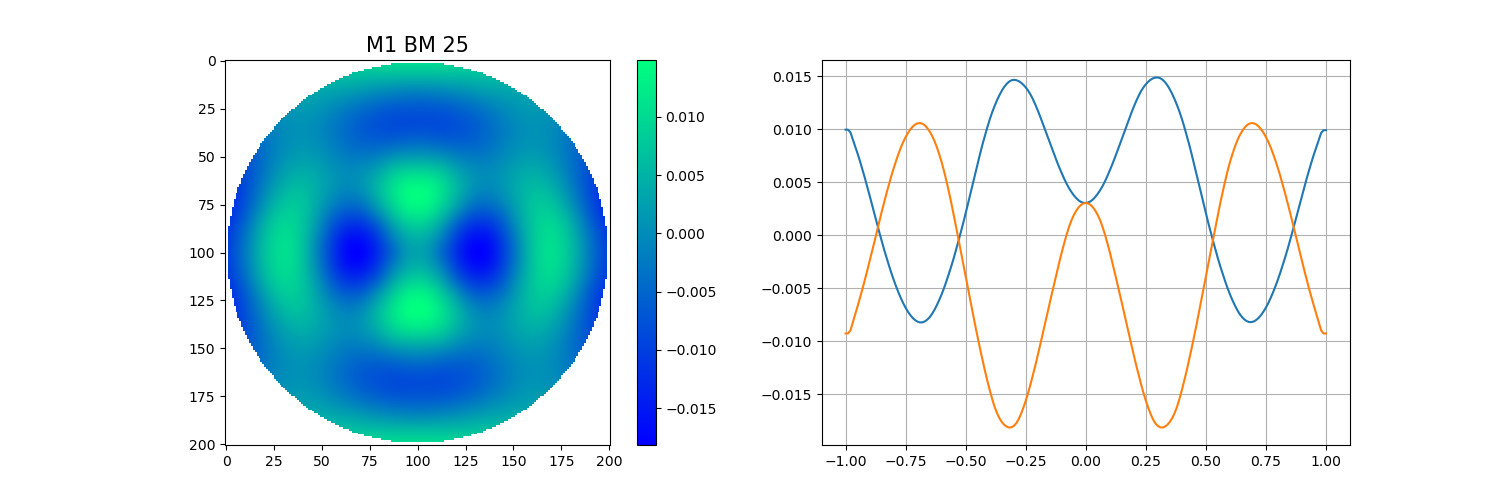

In [7]:
# Choose BM to display
this_set = 0    # 0: outer segments;    1: central segment
this_bm = 25

if this_set == 0:
    M1mask = M1masko
    M1np = M1npo
else:
    M1mask = M1maskc
    M1np = M1npc

BMmap = np.reshape(M[:,this_set*nbms+this_bm], (rows,cols), order='F')*M1mask
BMrms = np.sqrt( np.sum(BMmap[M1mask==1]**2)/M1np )
print("RMS of BM mode %d is: %.2f"%(this_bm, BMrms))
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
imm = ax1.imshow(BMmap, cmap=plt.cm.winter)
fig.colorbar(imm, ax=ax1)
ax1.set_title('M1 BM %d'%(this_bm), fontsize=15)

ax2.plot(xVec,BMmap[:,cols//2])
ax2.plot(yVec,BMmap[rows//2,:])
ax2.grid()
plt.show()

### On-axis Guide Star

In [8]:
# on-axis GS
nPx = 512 # number of pixels across D 
gs = ceo.Source("R+I",zenith=0.,azimuth=0.,
        rays_box_size=D, rays_box_sampling=nPx, rays_origin=[0.0,0.0,25])


In [9]:
# Define optical path (on-axis)
gs>>(gmt,)

## Apply GMT DoFs and acquire the WF map in the exit pupil

In [10]:
~gmt
+gs
amplitude = gs.wavefront.amplitude.host().ravel()
phase_ref = gs.wavefront.phase.host().ravel()
validpts = np.where(amplitude)[0]
nphasevals = len(validpts)

<IPython.core.display.Javascript object>


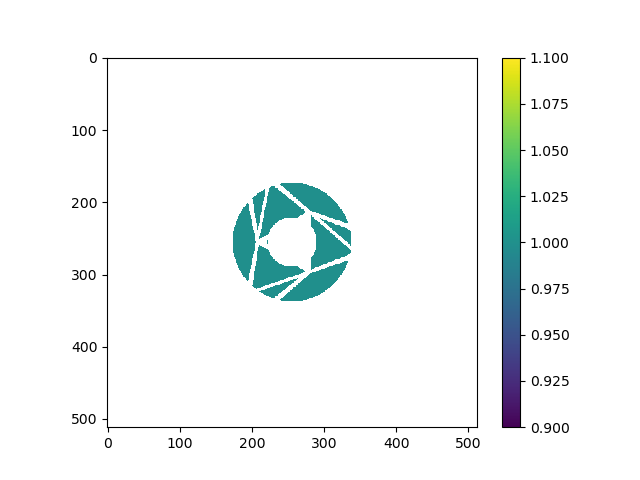

In [11]:
P = np.squeeze(np.array(gs.rays.piston_mask))
GMTmask = np.sum(P,axis=0).astype('bool')
npseg = np.sum(P,axis=1)
nmaskPup = np.sum(P) # number of valid mask points over each segment

# Make stacked array containing all segment masks
segment = np.zeros((7,nPx,nPx))
for i in range(7):
    temp = np.full(nPx**2, np.nan)
    temp[P[i,:]] = 1.0
    segment[i] = np.reshape(temp,(nPx,nPx))
plt.figure()
plt.imshow(segment[6,:,:])
plt.colorbar()
plt.show()

### M1 segment bending modes

In [12]:
BMtophase = np.zeros((nphasevals,M1_n_modes*7))

poke = 100e-9  # amplitude coefficient
for sid in range(7):
    for k in range(M1_n_modes):
        ~gmt
        state = gmt.state
        state['M1']['modes'][sid,k] = poke
        gmt^=state
        +gs
        BMtophase[:,k+M1_n_modes*sid] = (gs.wavefront.phase.host().ravel() - phase_ref)[validpts]

BMtophase /= poke
~gmt

##### Show a particular mode, just for fun

<IPython.core.display.Javascript object>


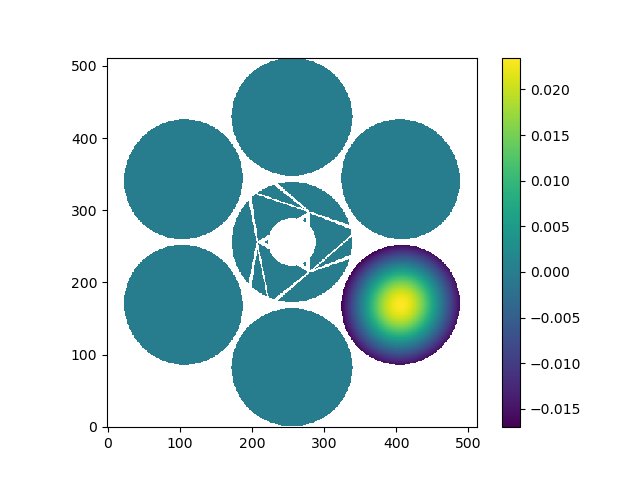

In [13]:
this_bm  = 2
this_seg = 2 

temp = np.full(nPx**2, np.nan)
temp[validpts] = BMtophase[:,this_seg*M1_n_modes+this_bm]
plt.figure()
plt.imshow(np.reshape(temp,(nPx,nPx)),interpolation='None', origin='lower')
plt.colorbar()
plt.show()

### M1 segment rigid body motions
1. Txyz: Translations along x, y and z axes [in m]
2. Rxyz: Rotations about x, y, and z axes [in rad]

In [14]:
#-- Calibrate interaction matrix between M1 Txyz and phase maps
M1Txyztophase = np.zeros((nphasevals,21))

poke = 1e-6
for sid in range(7):
    for k in range(3):
        ~gmt
        state = gmt.state
        state['M1']['Txyz'][sid,k] = poke
        gmt^=state

        +gs
        M1Txyztophase[:,k+3*sid] = (gs.wavefront.phase.host().ravel() - phase_ref)[validpts]

M1Txyztophase /= poke

#-- Calibrate interaction matrix between M1 Rxyz and phase maps
M1Rxyztophase = np.zeros((nphasevals,21))

poke = 1e-6
for sid in range(7):
    for k in range(3):
        ~gmt
        state = gmt.state
        state['M1']['Rxyz'][sid,k] = poke
        gmt^=state

        +gs
        M1Rxyztophase[:,k+3*sid] = (gs.wavefront.phase.host().ravel() - phase_ref)[validpts]

M1Rxyztophase /= poke

##### Show a particular mode, just for fun

<IPython.core.display.Javascript object>


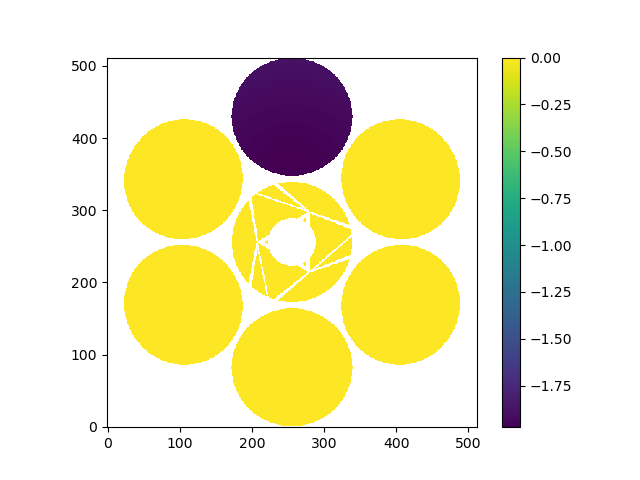

In [15]:
this_rbm  = 2
this_seg = 0 

temp = np.full(nPx**2, np.nan)
temp[validpts] = M1Txyztophase[:,this_seg*3+this_rbm]
plt.figure()
plt.imshow(np.reshape(temp,(nPx,nPx)),interpolation='None', origin='lower')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


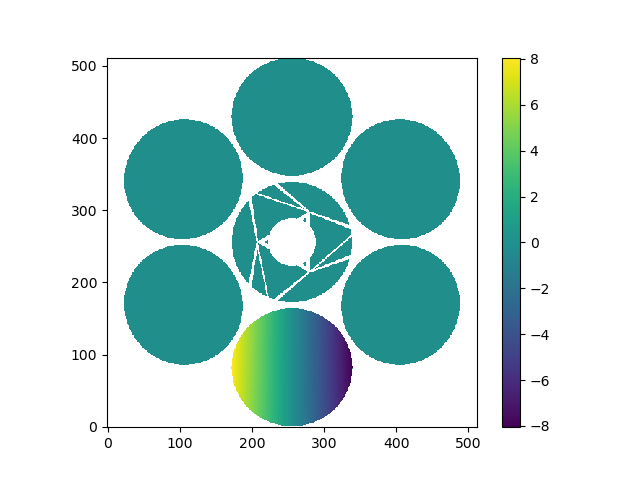

In [16]:
this_rbm  = 1
this_seg = 3 

temp = np.full(nPx**2, np.nan)
plt.figure()
temp[validpts] = M1Rxyztophase[:,this_seg*3+this_rbm]
plt.imshow(np.reshape(temp,(nPx,nPx)),interpolation='None', origin='lower')
plt.colorbar()
plt.show()

# Fit M1 DoFs with influence functions (ALPAO DM and PTT array)

To be done by UAH.

In [17]:
gmt_mask = amplitude > 0

<IPython.core.display.Javascript object>


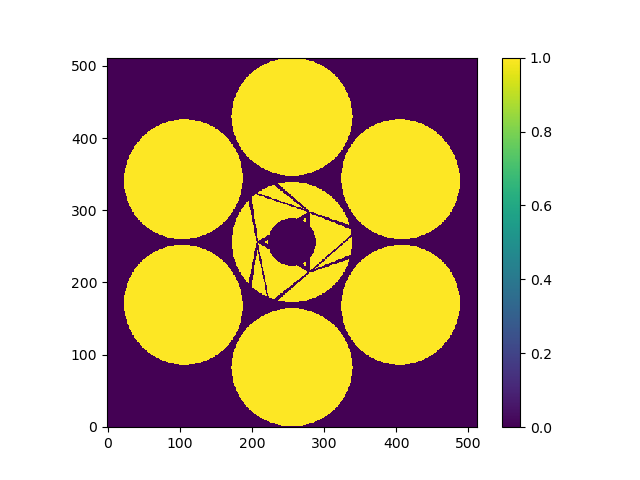

In [18]:
plt.figure()
plt.imshow(np.reshape(amplitude,(nPx,nPx)),interpolation='None', origin='lower')
plt.colorbar()
plt.show()

In [19]:
segment.shape[1]

512